## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [3]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [5]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [6]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [7]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBSBSS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
652
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|               res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|13513.667143923263|-2577.964214939354| -2187.423832306332|   2226.9|SBBBSBSS| 46.8333|   -110.7|       SNWD| 0.0701649195531972| 0.02974994734349932| 0.01798141739097821|0.

In [8]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_3|
+-----------+--------+---------+---------+-------------------+
|USC00244663| 46.8333|   -110.7|   2226.9| -2187.423832306332|
|USC00244663| 46.8333|   -110.7|   2226.9|-1193.3184258096223|
|USC00244663| 46.8333|   -110.7|   2226.9| 1848.6464653823323|
|USC00244663| 46.8333|   -110.7|   2226.9|-1380.4223397741625|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [9]:
Query="SELECT station, latitude,longitude,elevation,%s FROM weather where elevation < 0"%feature
print(Query)
df_neg = sqlContext.sql(Query)
#df_neg.show()
df.take(1)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather where elevation < 0


[Row(coeff_1=13513.667143923263, coeff_2=-2577.964214939354, coeff_3=-2187.423832306332, elevation=2226.9, label=u'SBBBSBSS', latitude=46.8333, longitude=-110.7, measurement=u'SNWD', res_1=0.0701649195531972, res_2=0.02974994734349932, res_3=0.01798141739097821, res_mean=0.9024297538523988, station=u'USC00244663', total_var=220520950.0, undefs=28, vector=bytearray(b"\xc3dwdDd+d+d+d+dDdDdDdwdDd^d^dwd\x90d\x90dwdwdwd\xc3d\xc3d\xddd)eBeBe)e\xf6d\xddd\xddd\xc3d\xc3d\xc3d)e\x8ee\xc1eue\\eBeBe)e\x0feBe\x0fe\xddd\xdddBe\x8ee\x8ee)e\xf6dBeBe)e\x0fe\xf6d\xddd\x0feueueueue\xa8eue\x8eeBeBe\xf6d)eBeue\\e)e)e\xf6d\xc3d\x90d\xc3d\xaad\xaad\xaadue\xa8e\xdbe\xf4e\xf4e\xf4e\xf4e\xf4e\xf4e\xf4e\'f\'f\rf\xf4e\xc1e\rf\rf\rf\xf4e\xc1e\xf4e\\eBeBe)e)e\xf6d\xc3d\xf6d\xf6d\xc3d\xaad\x90dwd^dDdDd+d\xf0c\xf4a\xc2a(a\xf6`\xc4`\xc4`\xc4`\xf6`\xc4`\xc4`\xc4`\xc4`\xc4`\xf0_\xc4`^`\xf0_$_\xf4]\x00~\xc4`\x90`^`*`\xf0_\xf0_\x8c_$_$_\xc0^X^\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~

In [10]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
#pdf.sort_values(by=['station'],inplace=True)
pdf.sort_values(by=['longitude'],inplace=True)
print pdf.head(1)
print pdf.tail(1)

        station  latitude  longitude  elevation  count(station)  avg(coeff_3)
29  USC00248927   46.5425  -110.9042     1572.8               9    110.828385
        station  latitude  longitude  elevation  count(station)  avg(coeff_3)
38  USC00244007   47.5667     -106.7      808.0              17    161.025911


In [11]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

print get_color(200.)

#ff4e00


## Map

In [12]:
min_lat,max_lat,min_long,max_long = box = (46.3619, 47.6422, -110.9042, -106.7)


In [13]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    if row['elevation'] < 0:
        col = '#000'
    else:
        col='#F00' 
    
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color=col, opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

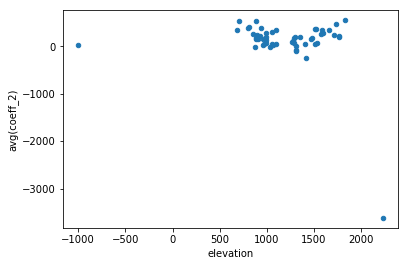

In [52]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_2)');

In [63]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']